# Fachprojekt Machine Learning
**Authors:** Anastasiia Korzhylova, Ivan Shishkin, Ramneek Agnihotri, Rodi Mehi

**Due date:** Wednesday, 3. July 2024

## Import necessary components

In [47]:
# Import the necessary libraries
import time, warnings
from tabulate import tabulate
import torch, torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR

# Import the VAE and VQ-VAE model and functions
import vae, vq_vae
from datasets import create_datasets
from evaluation import evaluate
from sampling import sample, plot_reconstruction
from plotting import plot_loss_lr, plot_loss_components

## Set model, hyperparameters, loss function and optimizing tools

In [48]:
# Hyperparameters
batch_size = 128 # Number of images per update of the network
num_epochs = 50 # One epoch means seeing every image of the training dataset
latent_dim = 256  # Size of the latent space
input_channels = 3  # CIFAR-10 images have 3 color channels
num_embeddings = 512 # Number of embeddings for VQ-VAE
commitment_cost = 0.25 # Commitment cost for VQ-VAE
learning_rate = 5e-5 # Determines how drastically the parameters of the network change
output_frequency = 150 # Determines how often the training progress will be logged (in batches)

# Select the device that will be used for training: GPU, if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('=========================================')

# Select the model and the loss function
model_option = 'vq-vae'

if model_option == 'vae':
  model = vae.VAE(input_channels, latent_dim)

  def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + 0.0001*KLD, MSE, KLD
else:
  model = vq_vae.VQVAE(input_channels, latent_dim, num_embeddings, commitment_cost)

  def loss_function(recon_x, x, vq_loss):
    MSE = F.mse_loss(recon_x, x, reduction='mean')
    return MSE + 10*vq_loss, MSE, vq_loss

model.to(device)

# Optimizer selection
optimizer_option = 'adamw'

if optimizer_option == "adam":
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
else:
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Learning rate scheduler parameters
lr_schedule_option = 'cosine'

scheduler = None
if lr_schedule_option == 'step':
  scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
elif lr_schedule_option == 'exponential':
  scheduler = ExponentialLR(optimizer, gamma=0.9)
elif lr_schedule_option == 'cosine':
  scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

# Scaler for AMP
scaler = torch.cuda.amp.GradScaler()

Using device: cuda


## Choose a dataset for training

Files already downloaded and verified
Files already downloaded and verified


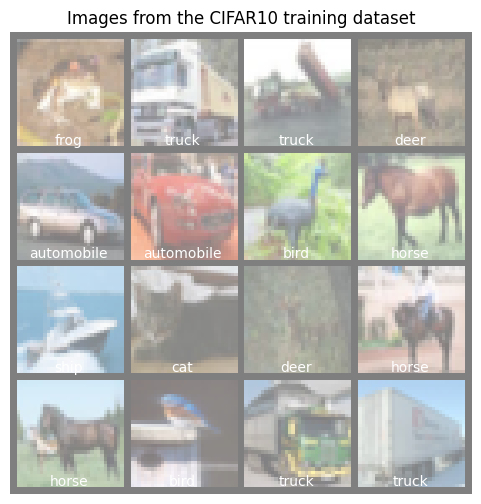

In [45]:
# Create and visualize the datasets for MNIST / CIFAR10
dataset_name = 'CIFAR10'
train_loader, test_loader = create_datasets(dataset_name, batch_size)

## Training loop

-----------------------------------------------------------------------------------------------------------------------------
Epoch:  1/ 50  Batch:    1  Train Loss:  0.100954  LR:  5e-05
Epoch:  1/ 50  Batch:  151  Train Loss:  0.240759  LR:  5e-05
Epoch:  1/ 50  Batch:  301  Train Loss:  0.192557  LR:  5e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       1 │           0.1836 │ 4.86s  │
╘═════════╧══════════════════╧════════╛


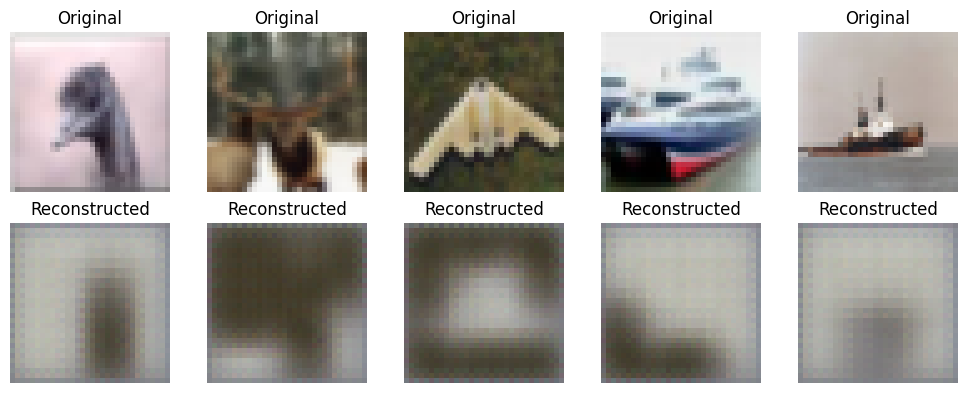

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  2/ 50  Batch:    1  Train Loss:  0.171892  LR:  4.99605e-05
Epoch:  2/ 50  Batch:  151  Train Loss:  0.138999  LR:  4.99605e-05
Epoch:  2/ 50  Batch:  301  Train Loss:  0.089261  LR:  4.99605e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       2 │           0.0526 │ 4.85s  │
╘═════════╧══════════════════╧════════╛


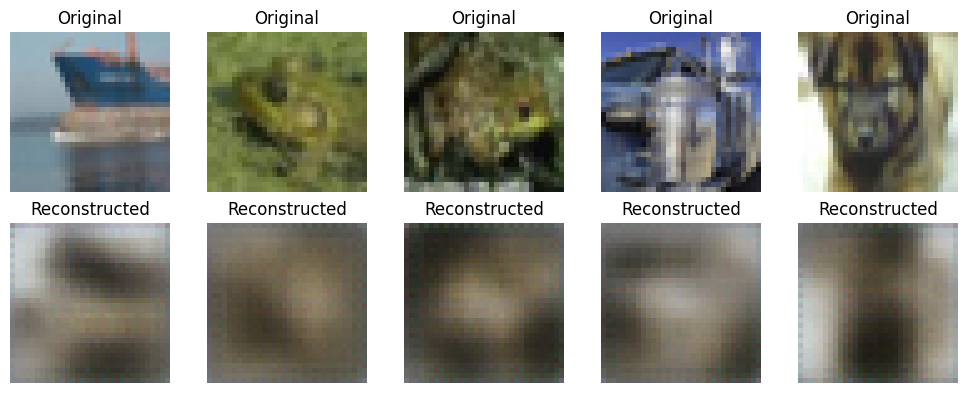

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  3/ 50  Batch:    1  Train Loss:  0.052215  LR:  4.98423e-05
Epoch:  3/ 50  Batch:  151  Train Loss:  0.057353  LR:  4.98423e-05
Epoch:  3/ 50  Batch:  301  Train Loss:  0.037658  LR:  4.98423e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       3 │           0.0351 │ 4.93s  │
╘═════════╧══════════════════╧════════╛


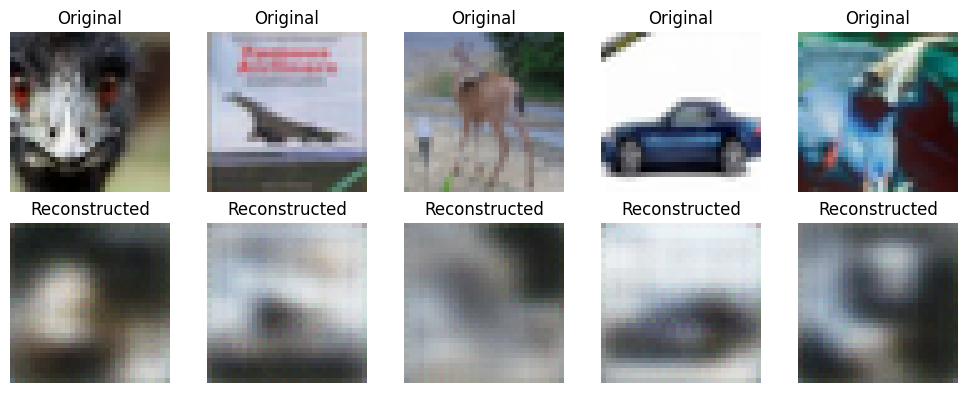

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  4/ 50  Batch:    1  Train Loss:  0.031073  LR:  4.96457e-05
Epoch:  4/ 50  Batch:  151  Train Loss:  0.030261  LR:  4.96457e-05
Epoch:  4/ 50  Batch:  301  Train Loss:  0.029239  LR:  4.96457e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       4 │           0.0297 │ 5.28s  │
╘═════════╧══════════════════╧════════╛


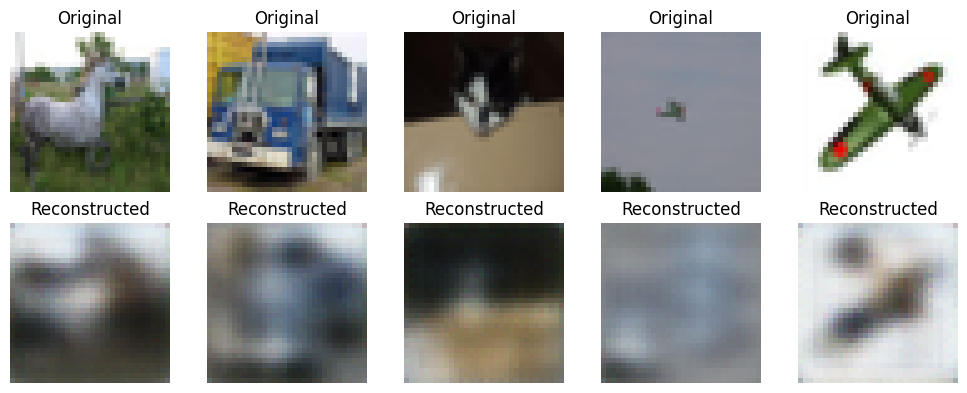

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  5/ 50  Batch:    1  Train Loss:  0.029509  LR:  4.93717e-05
Epoch:  5/ 50  Batch:  151  Train Loss:  0.028495  LR:  4.93717e-05
Epoch:  5/ 50  Batch:  301  Train Loss:  0.028088  LR:  4.93717e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       5 │           0.0275 │ 4.96s  │
╘═════════╧══════════════════╧════════╛


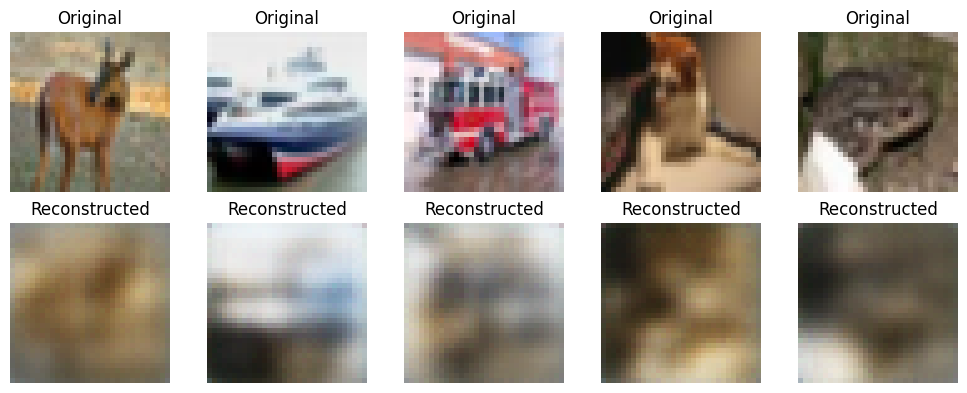

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  6/ 50  Batch:    1  Train Loss:  0.027615  LR:  4.90211e-05
Epoch:  6/ 50  Batch:  151  Train Loss:  0.027879  LR:  4.90211e-05
Epoch:  6/ 50  Batch:  301  Train Loss:  0.026989  LR:  4.90211e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       6 │           0.0264 │ 5.19s  │
╘═════════╧══════════════════╧════════╛


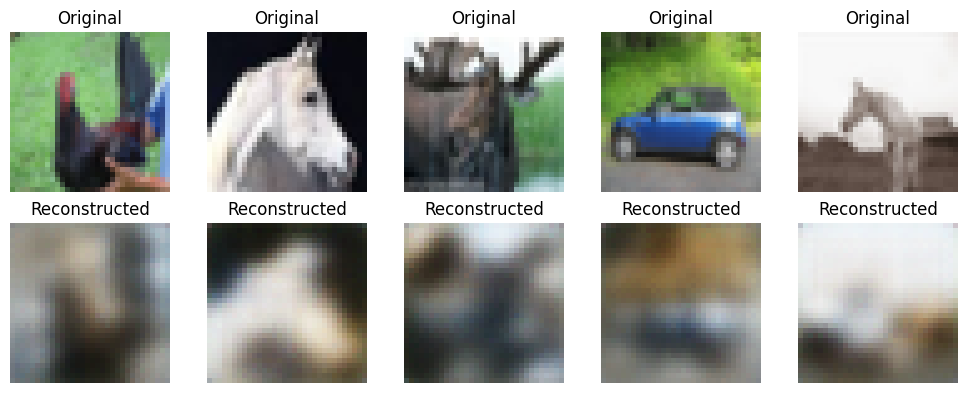

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  7/ 50  Batch:    1  Train Loss:  0.027174  LR:  4.85955e-05
Epoch:  7/ 50  Batch:  151  Train Loss:  0.027136  LR:  4.85955e-05
Epoch:  7/ 50  Batch:  301  Train Loss:  0.02626  LR:  4.85955e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       7 │           0.0258 │ 5.32s  │
╘═════════╧══════════════════╧════════╛


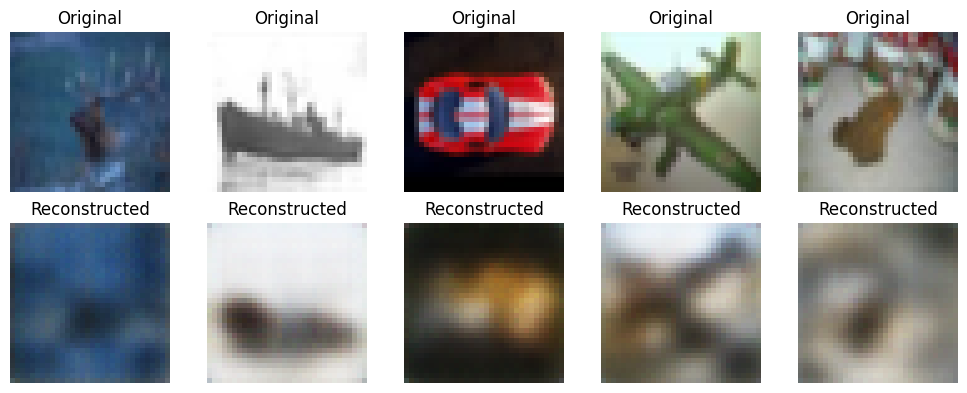

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  8/ 50  Batch:    1  Train Loss:  0.026405  LR:  4.80965e-05
Epoch:  8/ 50  Batch:  151  Train Loss:  0.024088  LR:  4.80965e-05
Epoch:  8/ 50  Batch:  301  Train Loss:  0.025717  LR:  4.80965e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       8 │           0.0253 │ 5.30s  │
╘═════════╧══════════════════╧════════╛


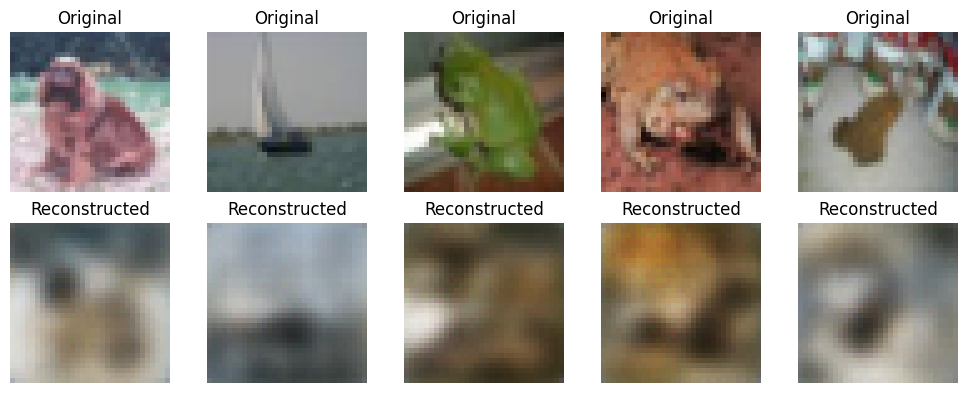

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  9/ 50  Batch:    1  Train Loss:  0.026529  LR:  4.75261e-05
Epoch:  9/ 50  Batch:  151  Train Loss:  0.025014  LR:  4.75261e-05
Epoch:  9/ 50  Batch:  301  Train Loss:  0.023928  LR:  4.75261e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       9 │           0.0251 │ 4.91s  │
╘═════════╧══════════════════╧════════╛


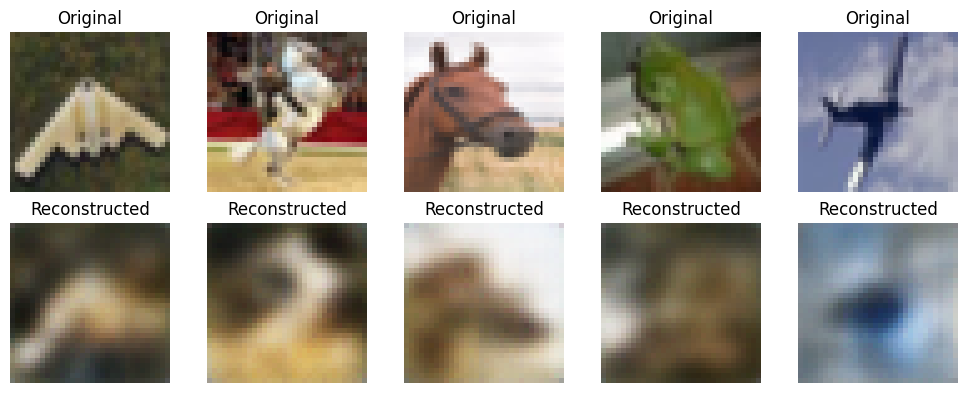

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  10/ 50  Batch:    1  Train Loss:  0.025582  LR:  4.68866e-05
Epoch:  10/ 50  Batch:  151  Train Loss:  0.02382  LR:  4.68866e-05
Epoch:  10/ 50  Batch:  301  Train Loss:  0.026182  LR:  4.68866e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      10 │           0.0248 │ 5.03s  │
╘═════════╧══════════════════╧════════╛


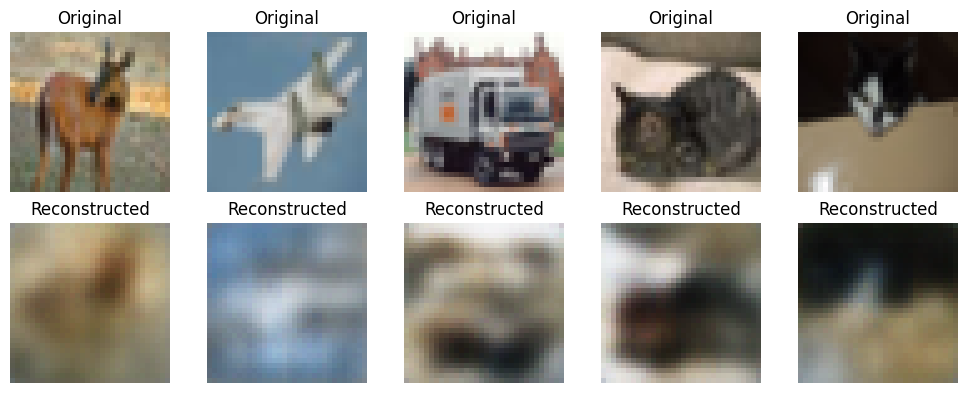

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  11/ 50  Batch:    1  Train Loss:  0.024225  LR:  4.61803e-05
Epoch:  11/ 50  Batch:  151  Train Loss:  0.024669  LR:  4.61803e-05
Epoch:  11/ 50  Batch:  301  Train Loss:  0.024517  LR:  4.61803e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      11 │           0.0251 │ 5.14s  │
╘═════════╧══════════════════╧════════╛


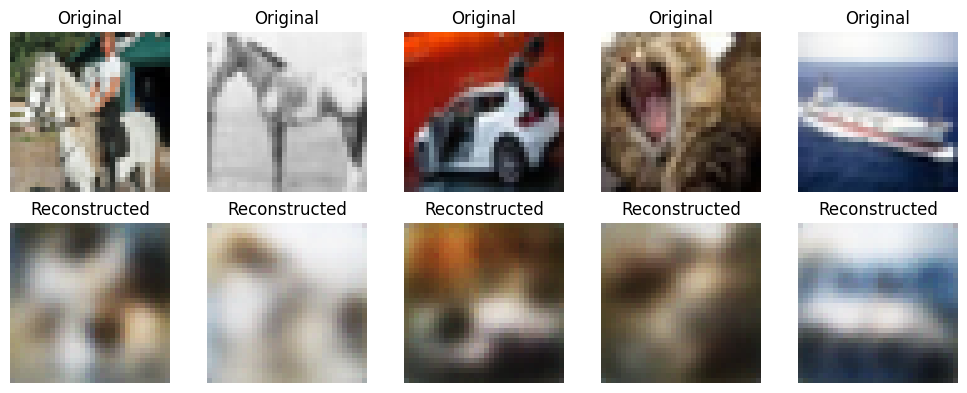

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  12/ 50  Batch:    1  Train Loss:  0.025751  LR:  4.54103e-05
Epoch:  12/ 50  Batch:  151  Train Loss:  0.025639  LR:  4.54103e-05
Epoch:  12/ 50  Batch:  301  Train Loss:  0.024993  LR:  4.54103e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      12 │           0.0256 │ 5.15s  │
╘═════════╧══════════════════╧════════╛


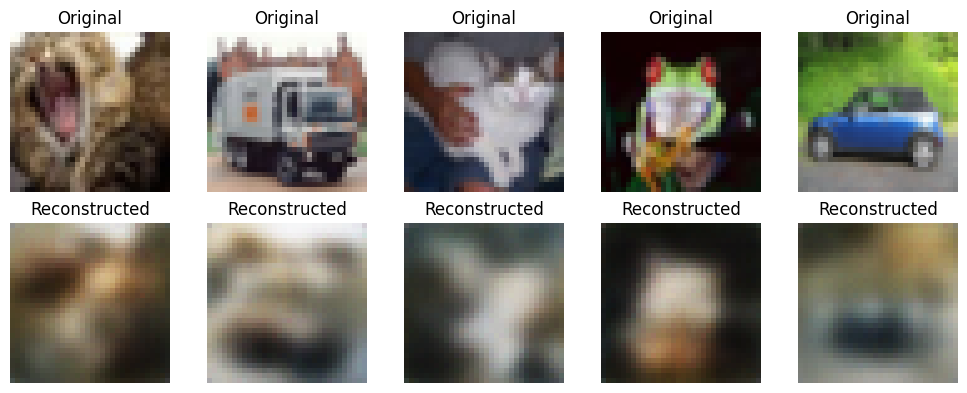

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  13/ 50  Batch:    1  Train Loss:  0.028735  LR:  4.45794e-05
Epoch:  13/ 50  Batch:  151  Train Loss:  0.0247  LR:  4.45794e-05
Epoch:  13/ 50  Batch:  301  Train Loss:  0.027001  LR:  4.45794e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      13 │           0.0267 │ 4.85s  │
╘═════════╧══════════════════╧════════╛


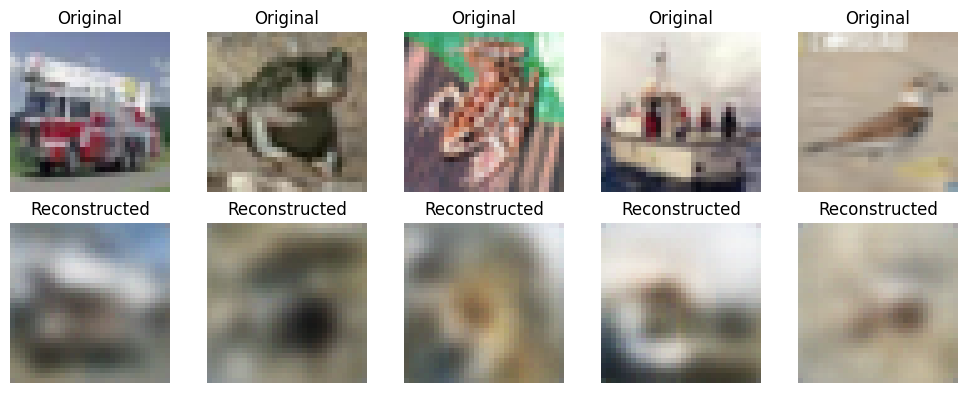

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  14/ 50  Batch:    1  Train Loss:  0.025615  LR:  4.36909e-05
Epoch:  14/ 50  Batch:  151  Train Loss:  0.027055  LR:  4.36909e-05
Epoch:  14/ 50  Batch:  301  Train Loss:  0.025612  LR:  4.36909e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      14 │           0.0271 │ 5.36s  │
╘═════════╧══════════════════╧════════╛


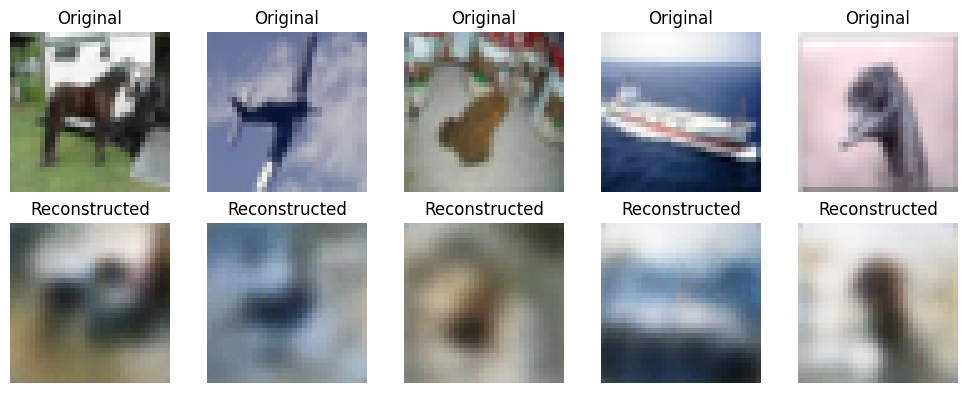

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  15/ 50  Batch:    1  Train Loss:  0.026536  LR:  4.27485e-05
Epoch:  15/ 50  Batch:  151  Train Loss:  0.027073  LR:  4.27485e-05
Epoch:  15/ 50  Batch:  301  Train Loss:  0.026935  LR:  4.27485e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      15 │           0.0271 │ 4.93s  │
╘═════════╧══════════════════╧════════╛


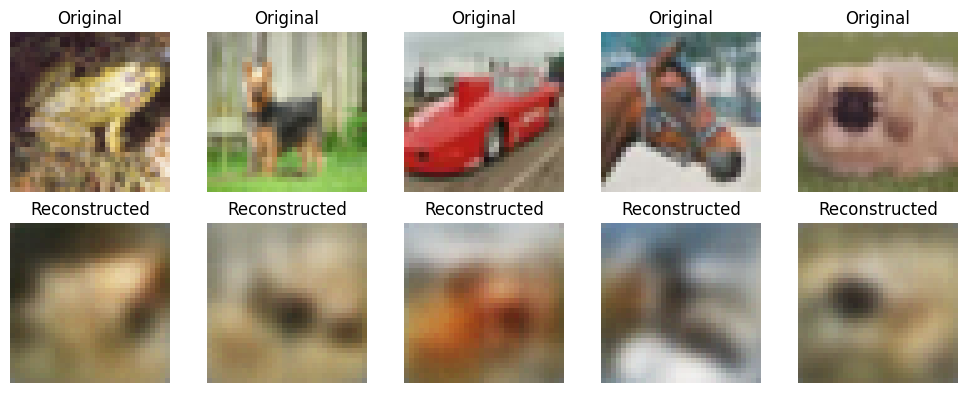

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  16/ 50  Batch:    1  Train Loss:  0.028464  LR:  4.17557e-05
Epoch:  16/ 50  Batch:  151  Train Loss:  0.028547  LR:  4.17557e-05
Epoch:  16/ 50  Batch:  301  Train Loss:  0.029563  LR:  4.17557e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      16 │           0.0271 │ 4.97s  │
╘═════════╧══════════════════╧════════╛


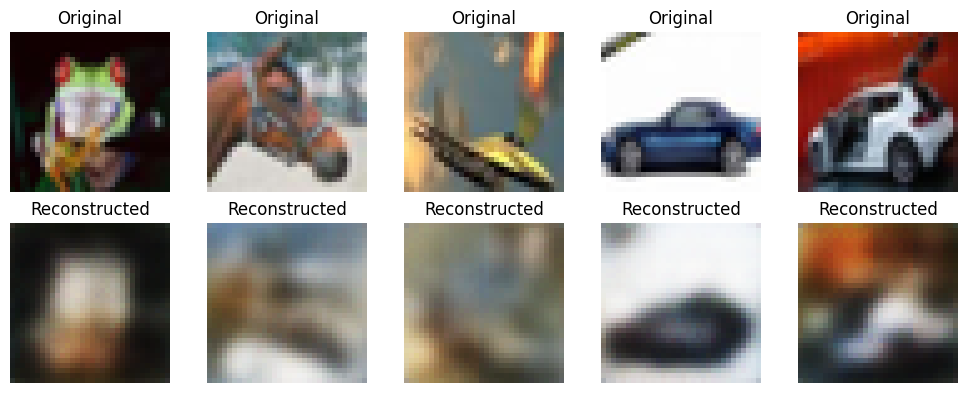

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  17/ 50  Batch:    1  Train Loss:  0.026312  LR:  4.07165e-05
Epoch:  17/ 50  Batch:  151  Train Loss:  0.028841  LR:  4.07165e-05
Epoch:  17/ 50  Batch:  301  Train Loss:  0.027328  LR:  4.07165e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      17 │           0.0273 │ 4.97s  │
╘═════════╧══════════════════╧════════╛


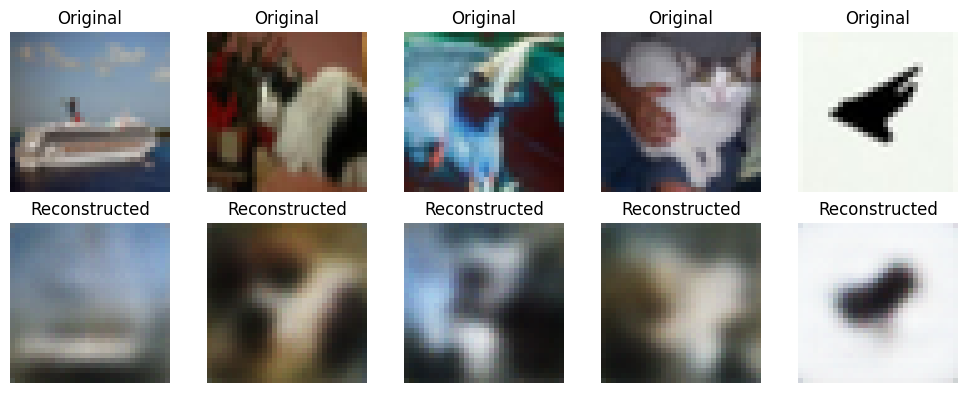

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  18/ 50  Batch:    1  Train Loss:  0.027502  LR:  3.96351e-05
Epoch:  18/ 50  Batch:  151  Train Loss:  0.026554  LR:  3.96351e-05
Epoch:  18/ 50  Batch:  301  Train Loss:  0.027514  LR:  3.96351e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      18 │           0.0274 │ 5.17s  │
╘═════════╧══════════════════╧════════╛


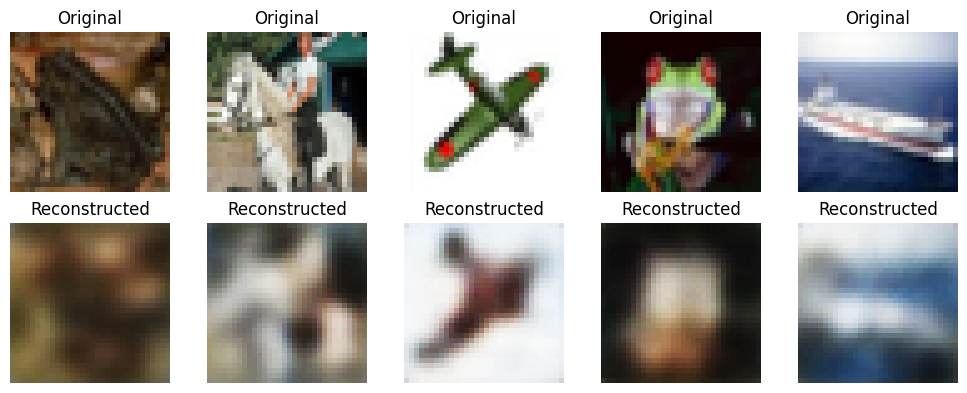

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  19/ 50  Batch:    1  Train Loss:  0.027124  LR:  3.85156e-05
Epoch:  19/ 50  Batch:  151  Train Loss:  0.026596  LR:  3.85156e-05
Epoch:  19/ 50  Batch:  301  Train Loss:  0.025997  LR:  3.85156e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      19 │           0.0273 │ 5.38s  │
╘═════════╧══════════════════╧════════╛


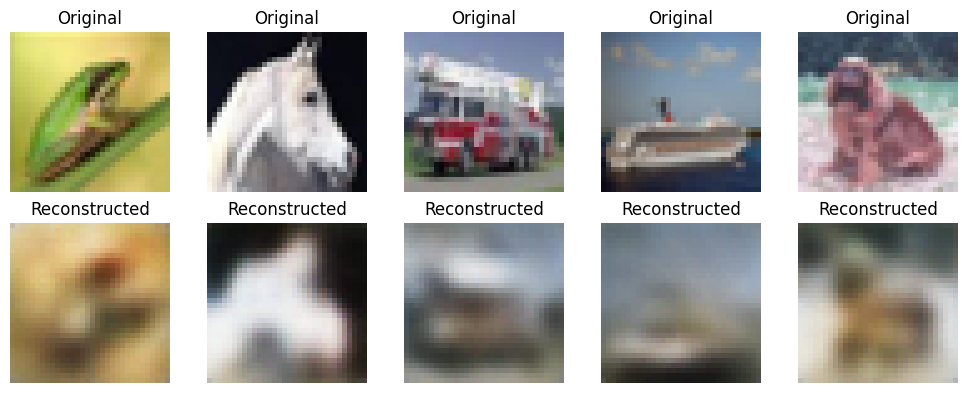

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  20/ 50  Batch:    1  Train Loss:  0.027363  LR:  3.73625e-05
Epoch:  20/ 50  Batch:  151  Train Loss:  0.028684  LR:  3.73625e-05
Epoch:  20/ 50  Batch:  301  Train Loss:  0.026376  LR:  3.73625e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      20 │           0.0275 │ 5.31s  │
╘═════════╧══════════════════╧════════╛


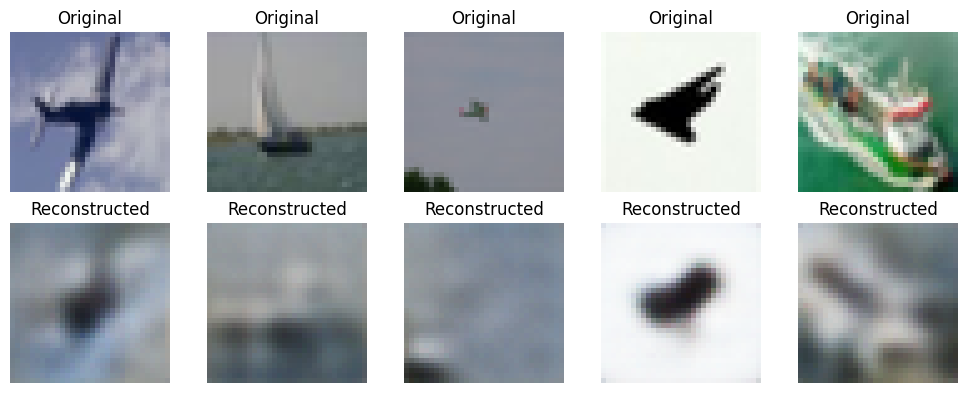

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  21/ 50  Batch:    1  Train Loss:  0.026746  LR:  3.61803e-05
Epoch:  21/ 50  Batch:  151  Train Loss:  0.029006  LR:  3.61803e-05
Epoch:  21/ 50  Batch:  301  Train Loss:  0.026457  LR:  3.61803e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      21 │           0.0278 │ 4.78s  │
╘═════════╧══════════════════╧════════╛


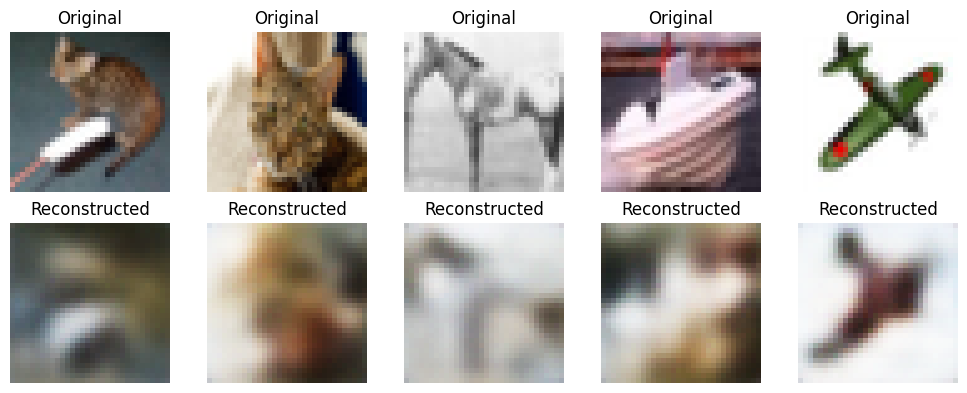

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  22/ 50  Batch:    1  Train Loss:  0.027897  LR:  3.49738e-05
Epoch:  22/ 50  Batch:  151  Train Loss:  0.029275  LR:  3.49738e-05
Epoch:  22/ 50  Batch:  301  Train Loss:  0.028155  LR:  3.49738e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      22 │            0.028 │ 5.01s  │
╘═════════╧══════════════════╧════════╛


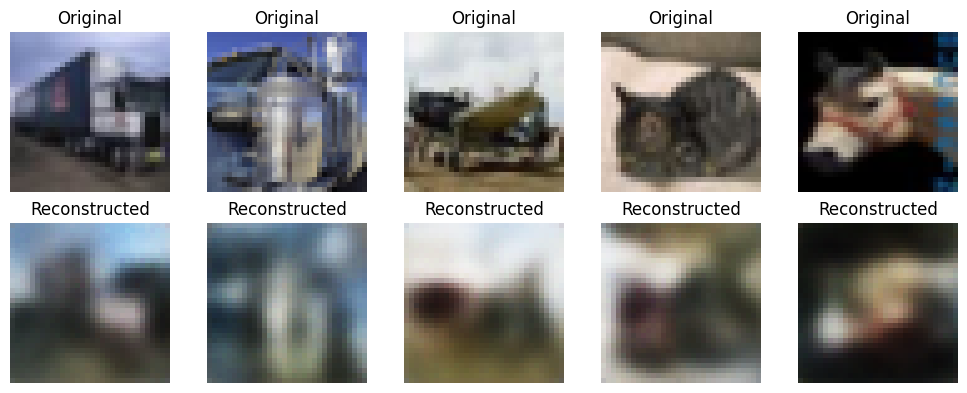

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  23/ 50  Batch:    1  Train Loss:  0.027769  LR:  3.37476e-05
Epoch:  23/ 50  Batch:  151  Train Loss:  0.028309  LR:  3.37476e-05
Epoch:  23/ 50  Batch:  301  Train Loss:  0.02763  LR:  3.37476e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      23 │            0.028 │ 5.08s  │
╘═════════╧══════════════════╧════════╛


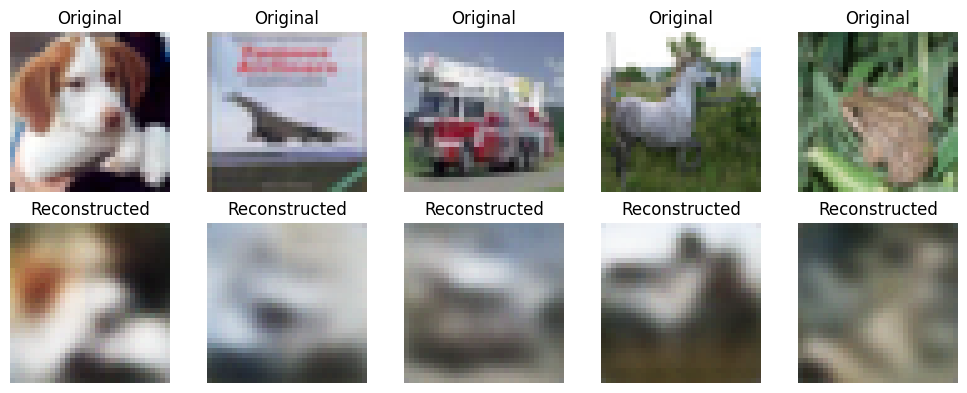

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  24/ 50  Batch:    1  Train Loss:  0.030451  LR:  3.25067e-05
Epoch:  24/ 50  Batch:  151  Train Loss:  0.029142  LR:  3.25067e-05
Epoch:  24/ 50  Batch:  301  Train Loss:  0.027825  LR:  3.25067e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      24 │           0.0281 │ 5.18s  │
╘═════════╧══════════════════╧════════╛


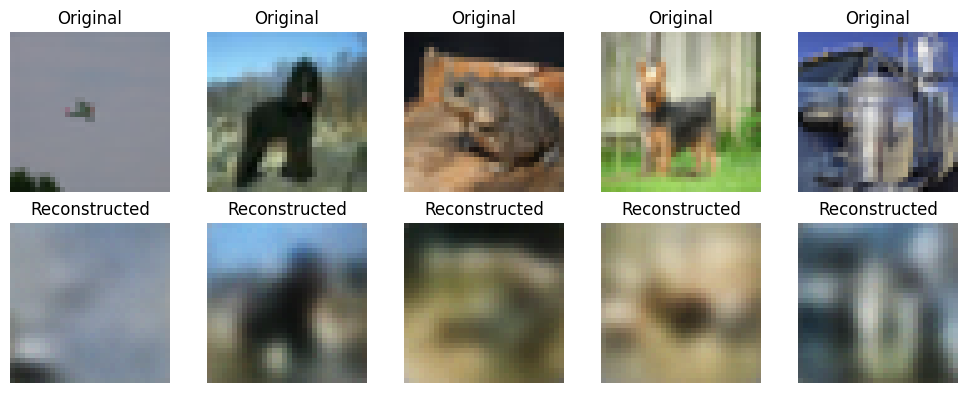

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  25/ 50  Batch:    1  Train Loss:  0.027525  LR:  3.12558e-05
Epoch:  25/ 50  Batch:  151  Train Loss:  0.028198  LR:  3.12558e-05
Epoch:  25/ 50  Batch:  301  Train Loss:  0.028121  LR:  3.12558e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      25 │            0.028 │ 4.95s  │
╘═════════╧══════════════════╧════════╛


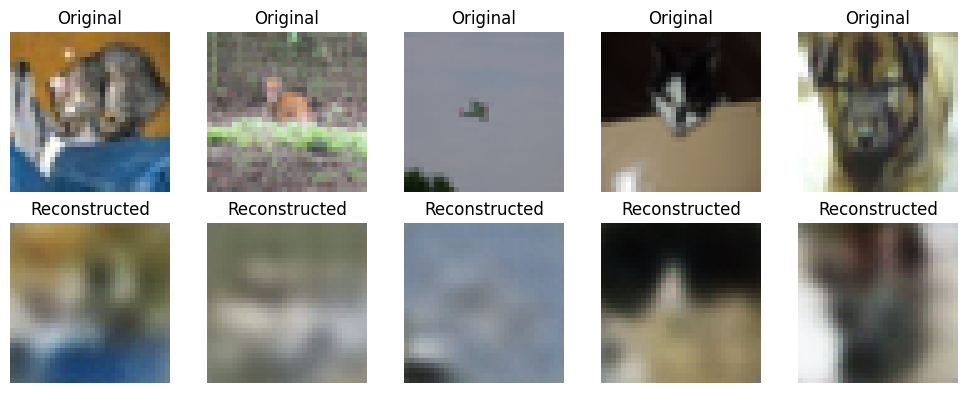

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  26/ 50  Batch:    1  Train Loss:  0.026494  LR:  3e-05
Epoch:  26/ 50  Batch:  151  Train Loss:  0.028154  LR:  3e-05
Epoch:  26/ 50  Batch:  301  Train Loss:  0.027034  LR:  3e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      26 │           0.0281 │ 5.02s  │
╘═════════╧══════════════════╧════════╛


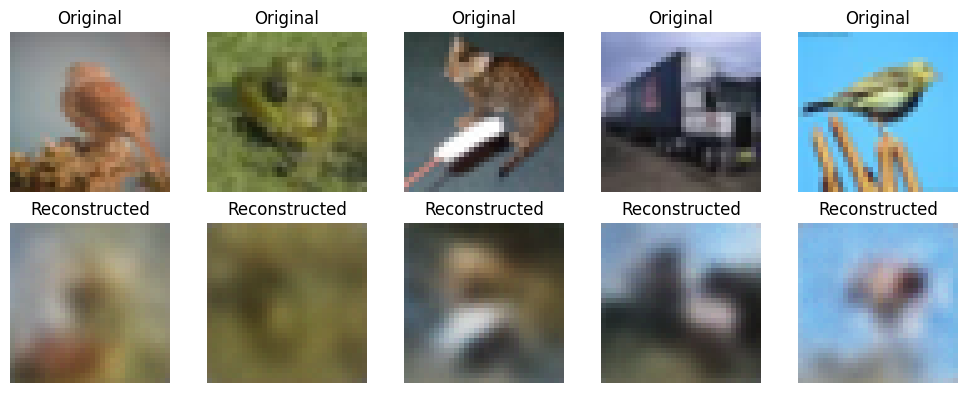

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  27/ 50  Batch:    1  Train Loss:  0.026846  LR:  2.87442e-05
Epoch:  27/ 50  Batch:  151  Train Loss:  0.030656  LR:  2.87442e-05
Epoch:  27/ 50  Batch:  301  Train Loss:  0.029498  LR:  2.87442e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      27 │           0.0281 │ 4.84s  │
╘═════════╧══════════════════╧════════╛


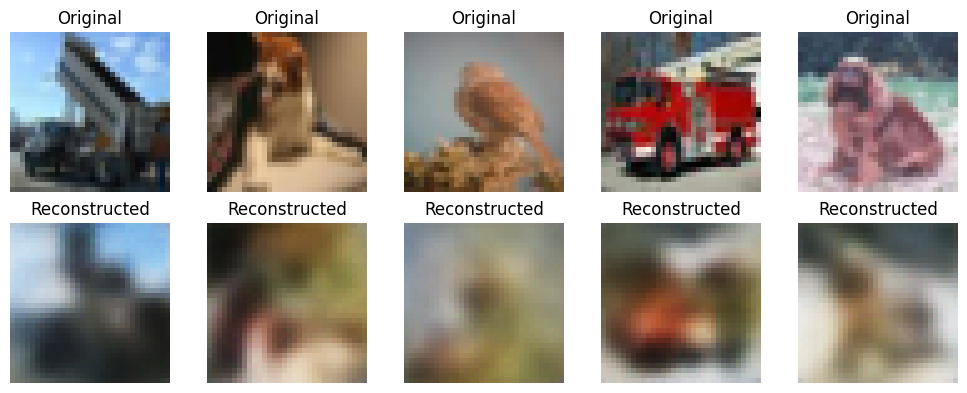

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  28/ 50  Batch:    1  Train Loss:  0.028139  LR:  2.74933e-05
Epoch:  28/ 50  Batch:  151  Train Loss:  0.02766  LR:  2.74933e-05
Epoch:  28/ 50  Batch:  301  Train Loss:  0.028801  LR:  2.74933e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      28 │            0.028 │ 5.21s  │
╘═════════╧══════════════════╧════════╛


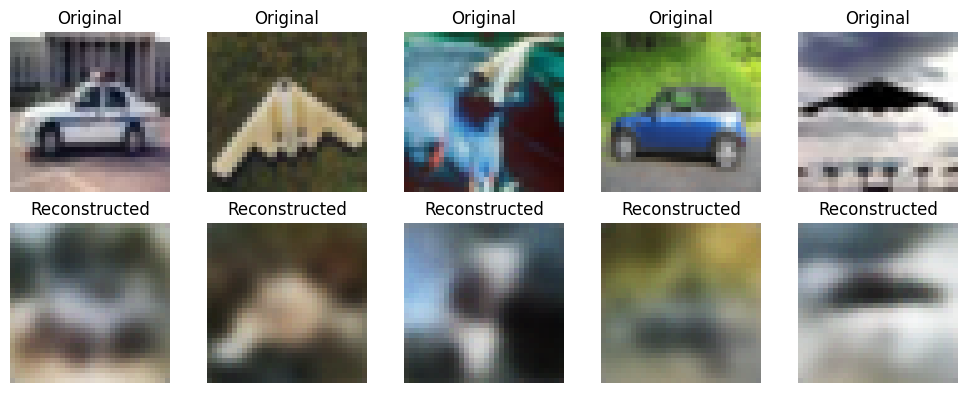

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  29/ 50  Batch:    1  Train Loss:  0.02759  LR:  2.62524e-05
Epoch:  29/ 50  Batch:  151  Train Loss:  0.027177  LR:  2.62524e-05
Epoch:  29/ 50  Batch:  301  Train Loss:  0.026598  LR:  2.62524e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      29 │           0.0281 │ 4.82s  │
╘═════════╧══════════════════╧════════╛


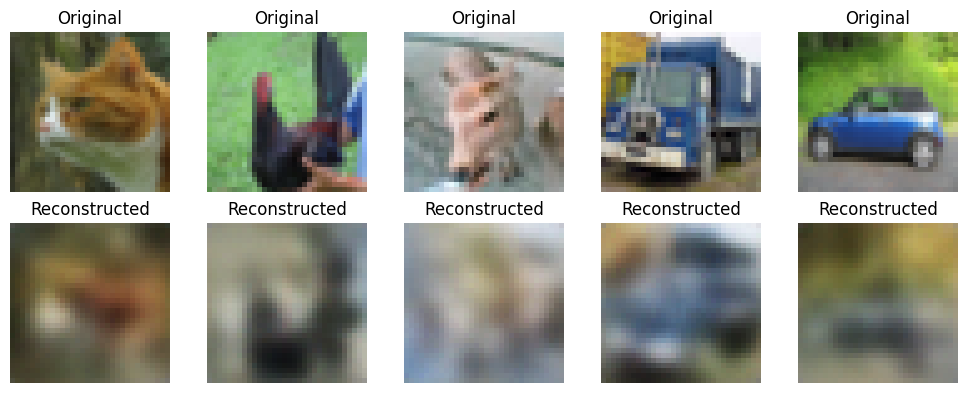

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  30/ 50  Batch:    1  Train Loss:  0.027786  LR:  2.50262e-05
Epoch:  30/ 50  Batch:  151  Train Loss:  0.028056  LR:  2.50262e-05
Epoch:  30/ 50  Batch:  301  Train Loss:  0.028405  LR:  2.50262e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      30 │           0.0281 │ 5.17s  │
╘═════════╧══════════════════╧════════╛


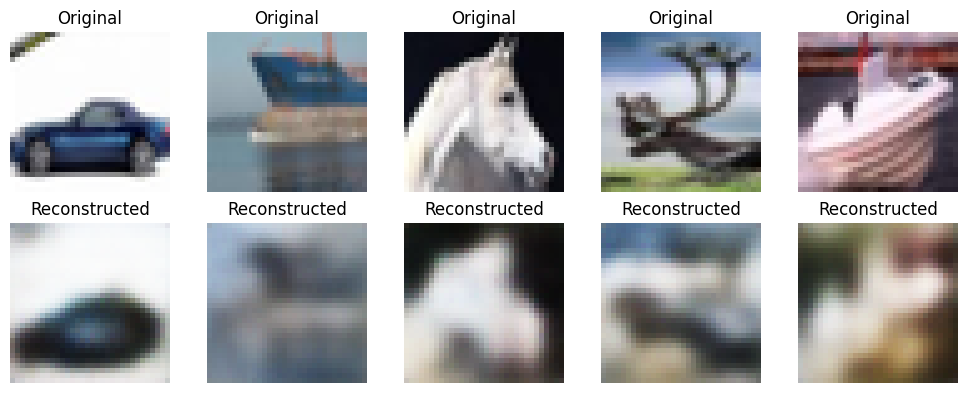

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  31/ 50  Batch:    1  Train Loss:  0.026947  LR:  2.38197e-05
Epoch:  31/ 50  Batch:  151  Train Loss:  0.027786  LR:  2.38197e-05
Epoch:  31/ 50  Batch:  301  Train Loss:  0.028682  LR:  2.38197e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      31 │           0.0282 │ 5.02s  │
╘═════════╧══════════════════╧════════╛


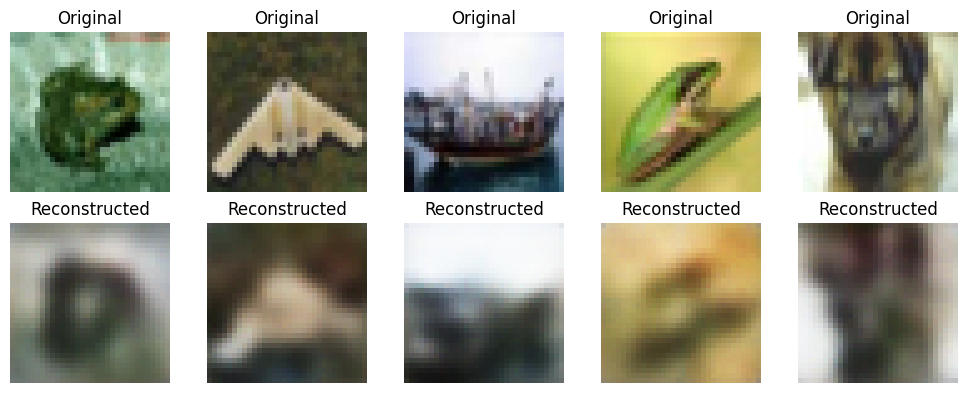

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  32/ 50  Batch:    1  Train Loss:  0.028093  LR:  2.26375e-05
Epoch:  32/ 50  Batch:  151  Train Loss:  0.027779  LR:  2.26375e-05
Epoch:  32/ 50  Batch:  301  Train Loss:  0.029687  LR:  2.26375e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      32 │           0.0281 │ 5.39s  │
╘═════════╧══════════════════╧════════╛


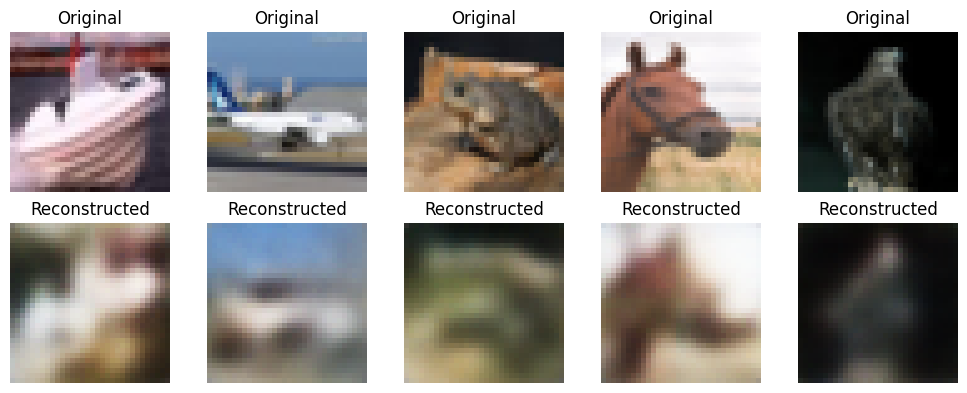

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  33/ 50  Batch:    1  Train Loss:  0.028209  LR:  2.14844e-05
Epoch:  33/ 50  Batch:  151  Train Loss:  0.029101  LR:  2.14844e-05
Epoch:  33/ 50  Batch:  301  Train Loss:  0.029292  LR:  2.14844e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      33 │            0.028 │ 4.90s  │
╘═════════╧══════════════════╧════════╛


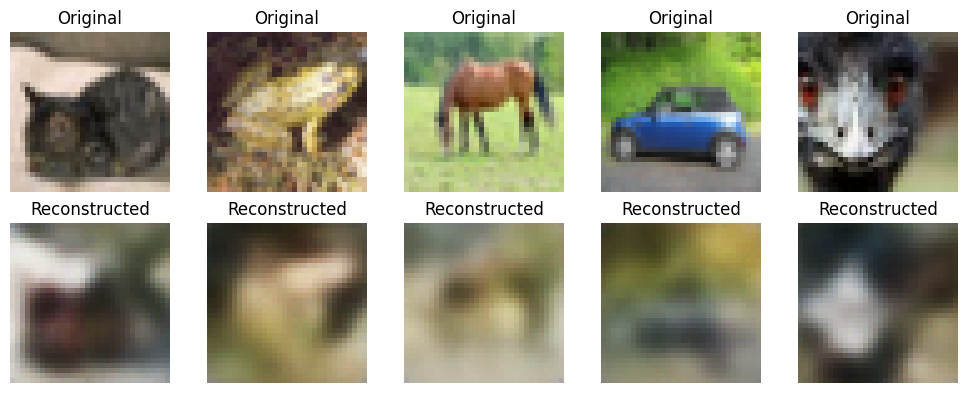

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  34/ 50  Batch:    1  Train Loss:  0.029412  LR:  2.03649e-05
Epoch:  34/ 50  Batch:  151  Train Loss:  0.028037  LR:  2.03649e-05
Epoch:  34/ 50  Batch:  301  Train Loss:  0.027161  LR:  2.03649e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      34 │           0.0282 │ 5.09s  │
╘═════════╧══════════════════╧════════╛


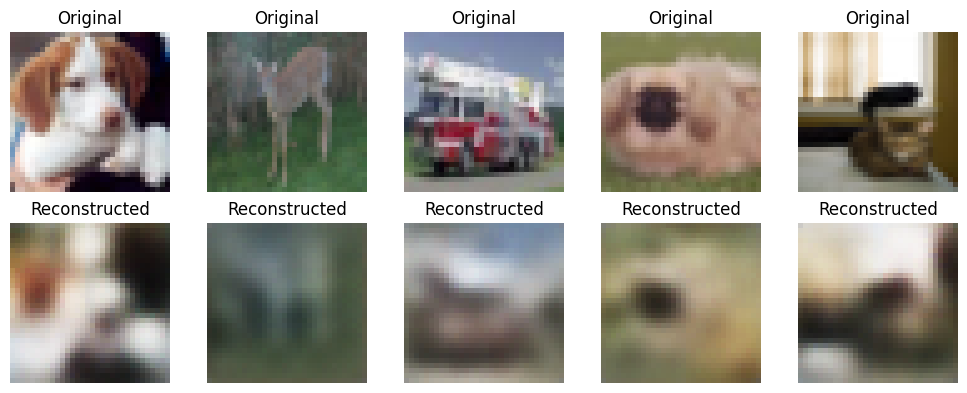

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  35/ 50  Batch:    1  Train Loss:  0.028083  LR:  1.92835e-05
Epoch:  35/ 50  Batch:  151  Train Loss:  0.030238  LR:  1.92835e-05
Epoch:  35/ 50  Batch:  301  Train Loss:  0.029305  LR:  1.92835e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      35 │           0.0282 │ 5.14s  │
╘═════════╧══════════════════╧════════╛


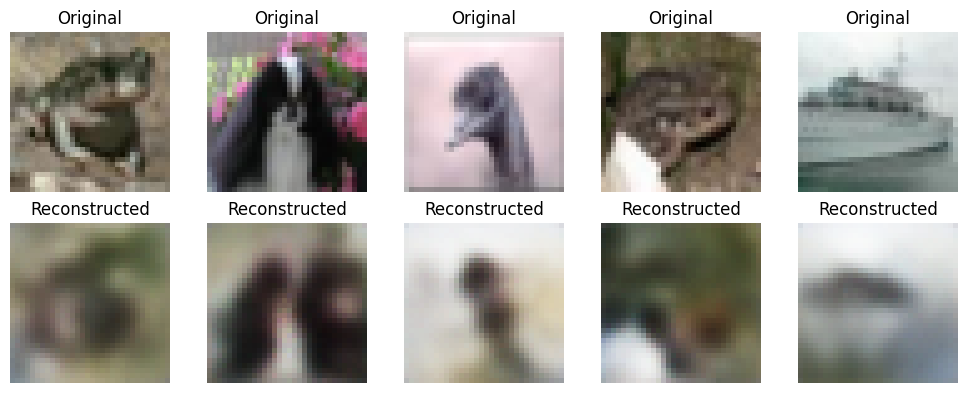

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  36/ 50  Batch:    1  Train Loss:  0.028889  LR:  1.82443e-05
Epoch:  36/ 50  Batch:  151  Train Loss:  0.027251  LR:  1.82443e-05
Epoch:  36/ 50  Batch:  301  Train Loss:  0.026885  LR:  1.82443e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      36 │           0.0283 │ 5.26s  │
╘═════════╧══════════════════╧════════╛


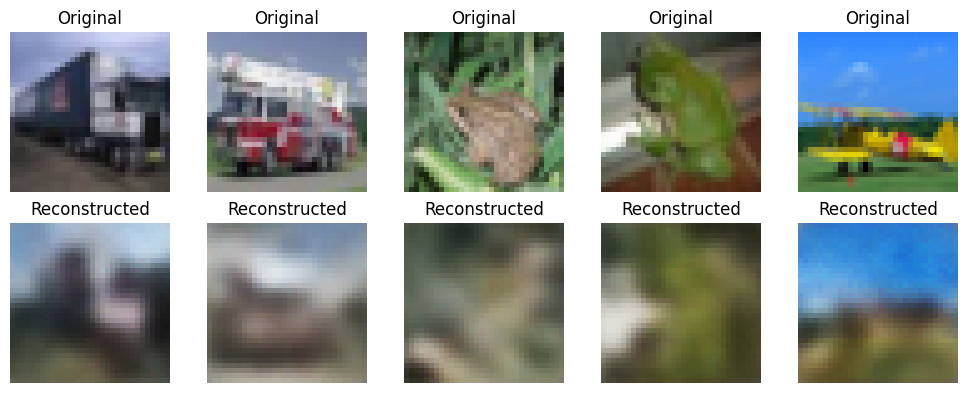

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  37/ 50  Batch:    1  Train Loss:  0.027525  LR:  1.72515e-05
Epoch:  37/ 50  Batch:  151  Train Loss:  0.027927  LR:  1.72515e-05
Epoch:  37/ 50  Batch:  301  Train Loss:  0.02781  LR:  1.72515e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      37 │           0.0282 │ 4.77s  │
╘═════════╧══════════════════╧════════╛


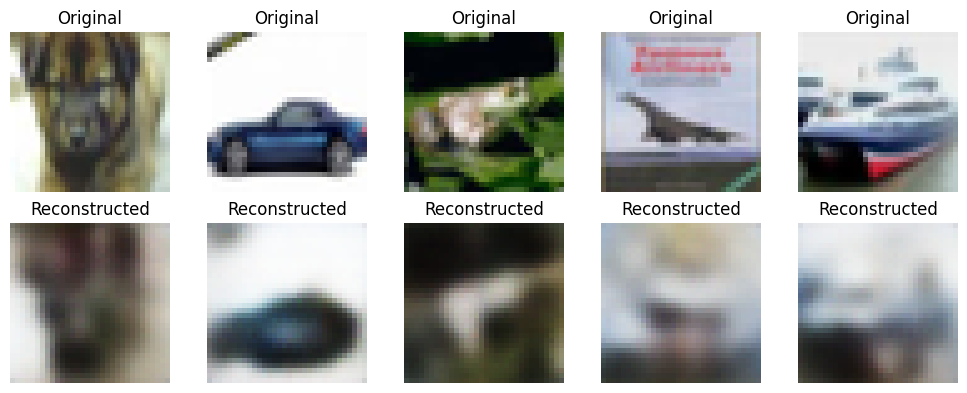

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  38/ 50  Batch:    1  Train Loss:  0.028653  LR:  1.63091e-05
Epoch:  38/ 50  Batch:  151  Train Loss:  0.027525  LR:  1.63091e-05
Epoch:  38/ 50  Batch:  301  Train Loss:  0.028414  LR:  1.63091e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      38 │           0.0283 │ 4.97s  │
╘═════════╧══════════════════╧════════╛


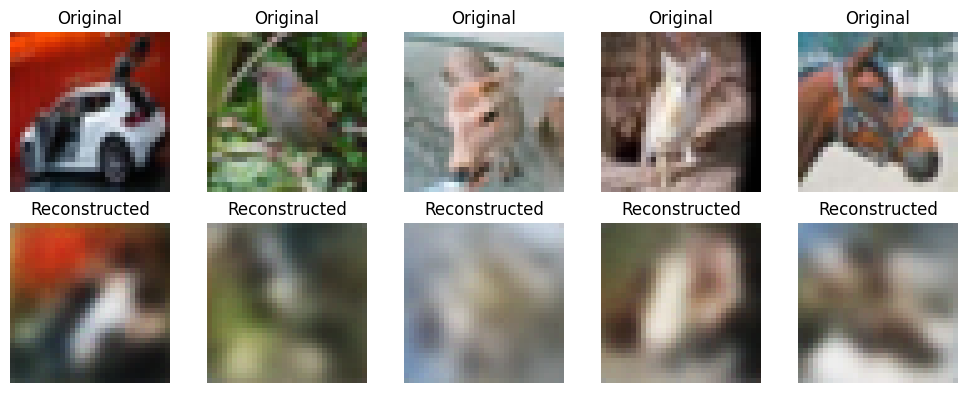

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  39/ 50  Batch:    1  Train Loss:  0.026867  LR:  1.54206e-05
Epoch:  39/ 50  Batch:  151  Train Loss:  0.030148  LR:  1.54206e-05
Epoch:  39/ 50  Batch:  301  Train Loss:  0.029317  LR:  1.54206e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      39 │           0.0283 │ 5.47s  │
╘═════════╧══════════════════╧════════╛


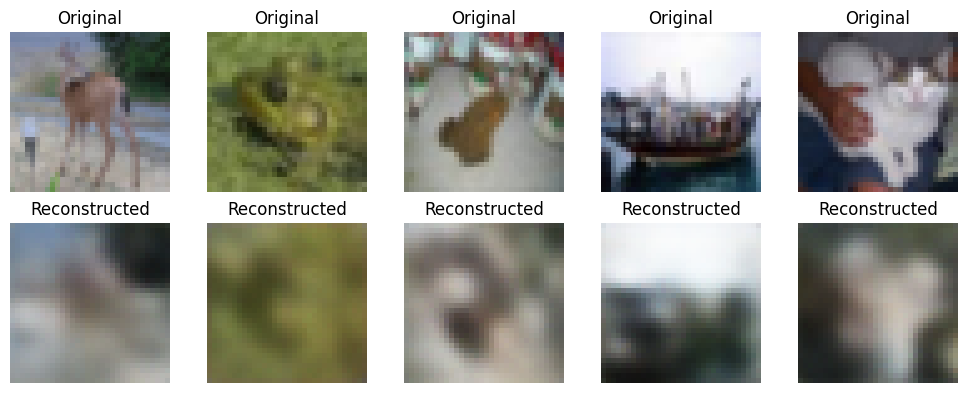

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  40/ 50  Batch:    1  Train Loss:  0.027316  LR:  1.45897e-05
Epoch:  40/ 50  Batch:  151  Train Loss:  0.028164  LR:  1.45897e-05
Epoch:  40/ 50  Batch:  301  Train Loss:  0.027414  LR:  1.45897e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      40 │           0.0283 │ 5.21s  │
╘═════════╧══════════════════╧════════╛


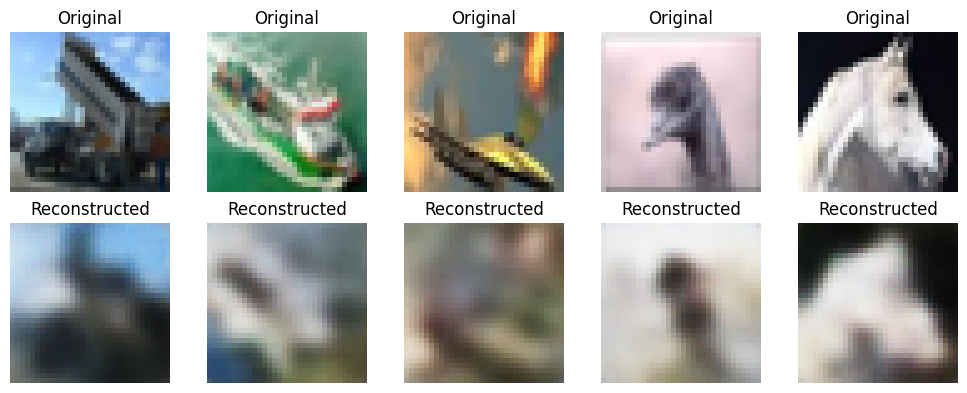

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  41/ 50  Batch:    1  Train Loss:  0.028251  LR:  1.38197e-05
Epoch:  41/ 50  Batch:  151  Train Loss:  0.029169  LR:  1.38197e-05
Epoch:  41/ 50  Batch:  301  Train Loss:  0.029218  LR:  1.38197e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      41 │           0.0283 │ 4.85s  │
╘═════════╧══════════════════╧════════╛


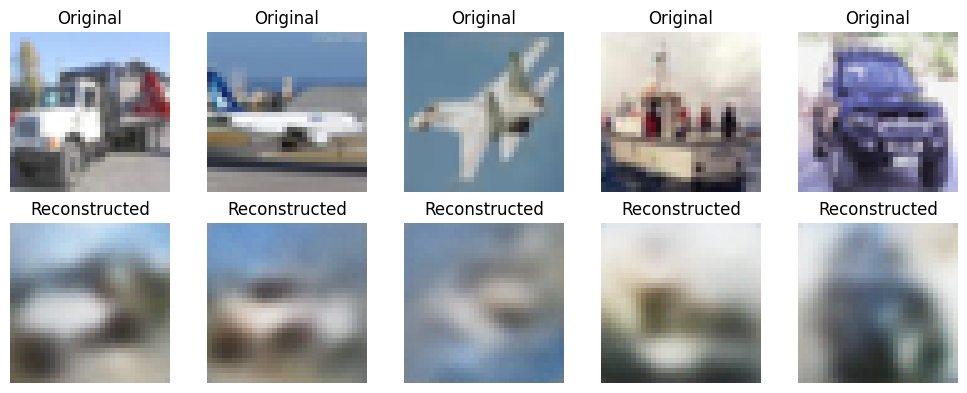

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  42/ 50  Batch:    1  Train Loss:  0.028243  LR:  1.31134e-05
Epoch:  42/ 50  Batch:  151  Train Loss:  0.02713  LR:  1.31134e-05
Epoch:  42/ 50  Batch:  301  Train Loss:  0.027653  LR:  1.31134e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      42 │           0.0284 │ 5.50s  │
╘═════════╧══════════════════╧════════╛


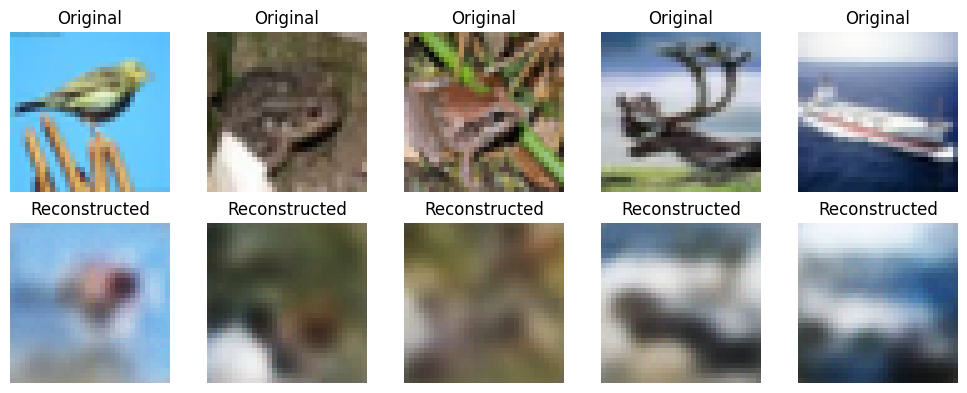

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  43/ 50  Batch:    1  Train Loss:  0.02748  LR:  1.24739e-05
Epoch:  43/ 50  Batch:  151  Train Loss:  0.028275  LR:  1.24739e-05
Epoch:  43/ 50  Batch:  301  Train Loss:  0.0289  LR:  1.24739e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      43 │           0.0283 │ 5.11s  │
╘═════════╧══════════════════╧════════╛


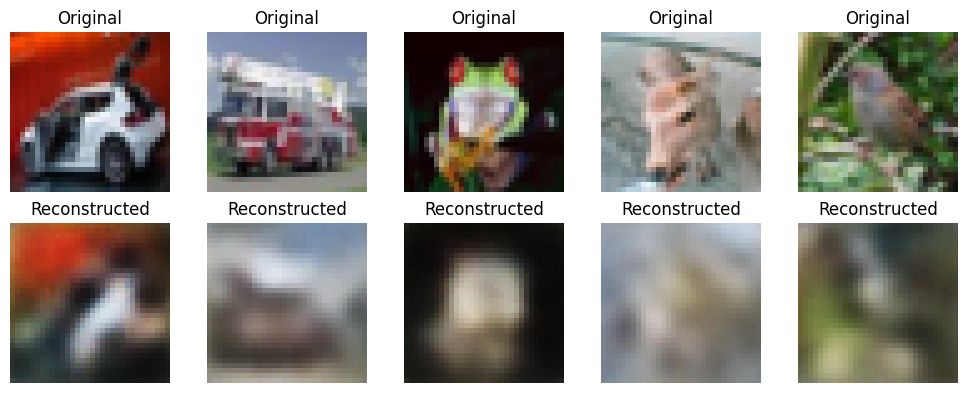

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  44/ 50  Batch:    1  Train Loss:  0.028031  LR:  1.19035e-05
Epoch:  44/ 50  Batch:  151  Train Loss:  0.029391  LR:  1.19035e-05
Epoch:  44/ 50  Batch:  301  Train Loss:  0.027999  LR:  1.19035e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      44 │           0.0283 │ 4.95s  │
╘═════════╧══════════════════╧════════╛


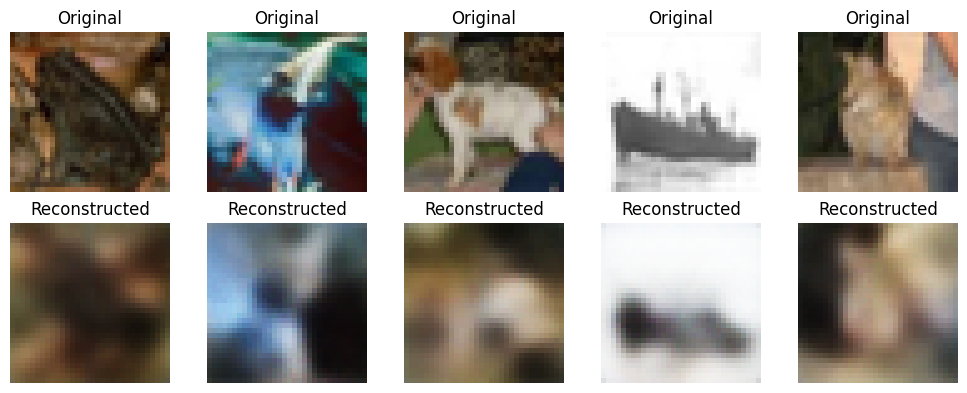

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  45/ 50  Batch:    1  Train Loss:  0.027429  LR:  1.14045e-05
Epoch:  45/ 50  Batch:  151  Train Loss:  0.028937  LR:  1.14045e-05
Epoch:  45/ 50  Batch:  301  Train Loss:  0.029841  LR:  1.14045e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      45 │           0.0284 │ 5.03s  │
╘═════════╧══════════════════╧════════╛


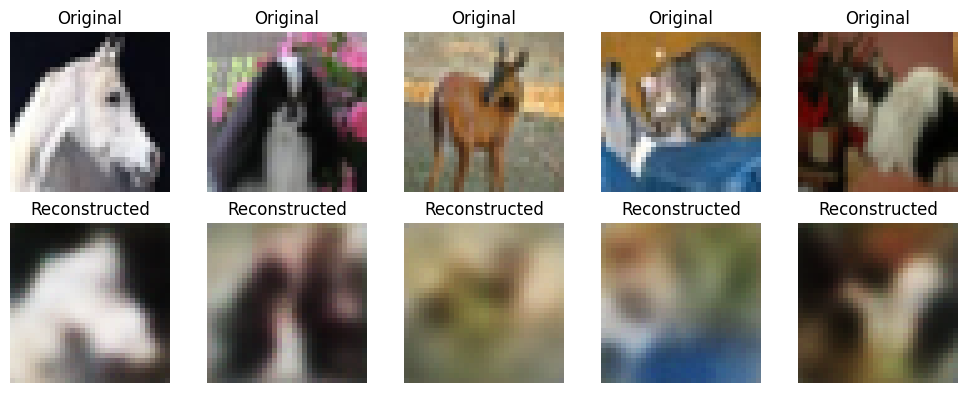

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  46/ 50  Batch:    1  Train Loss:  0.027165  LR:  1.09789e-05
Epoch:  46/ 50  Batch:  151  Train Loss:  0.027508  LR:  1.09789e-05
Epoch:  46/ 50  Batch:  301  Train Loss:  0.029441  LR:  1.09789e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      46 │           0.0284 │ 4.87s  │
╘═════════╧══════════════════╧════════╛


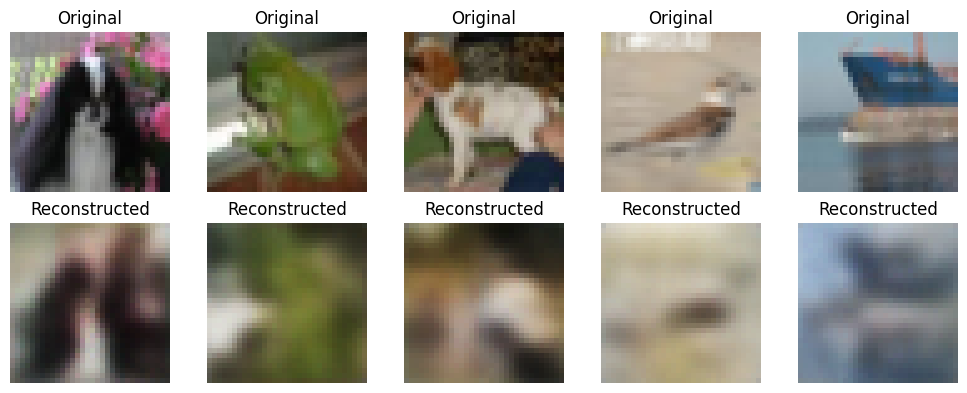

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  47/ 50  Batch:    1  Train Loss:  0.027041  LR:  1.06283e-05
Epoch:  47/ 50  Batch:  151  Train Loss:  0.029122  LR:  1.06283e-05
Epoch:  47/ 50  Batch:  301  Train Loss:  0.02834  LR:  1.06283e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      47 │           0.0283 │ 5.21s  │
╘═════════╧══════════════════╧════════╛


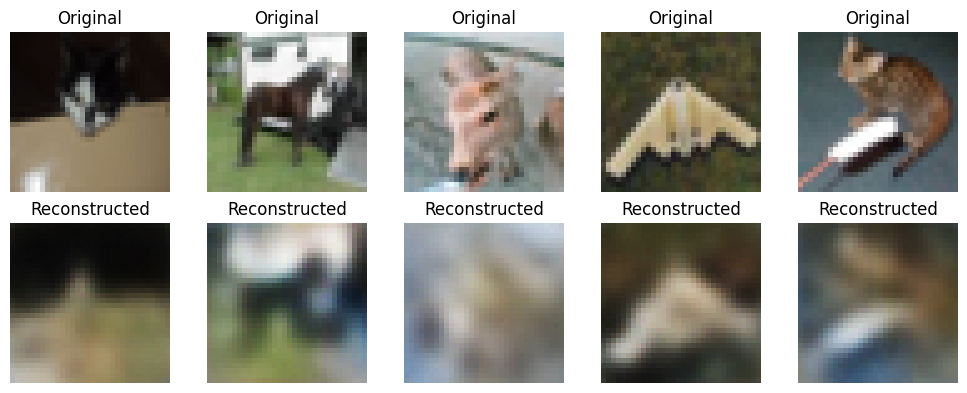

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  48/ 50  Batch:    1  Train Loss:  0.029031  LR:  1.03543e-05
Epoch:  48/ 50  Batch:  151  Train Loss:  0.027207  LR:  1.03543e-05
Epoch:  48/ 50  Batch:  301  Train Loss:  0.029922  LR:  1.03543e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      48 │           0.0283 │ 5.06s  │
╘═════════╧══════════════════╧════════╛


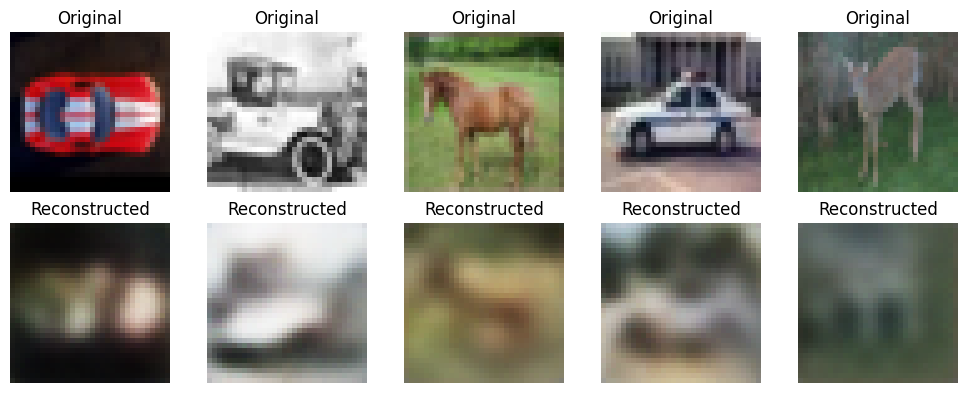

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  49/ 50  Batch:    1  Train Loss:  0.027809  LR:  1.01577e-05
Epoch:  49/ 50  Batch:  151  Train Loss:  0.028866  LR:  1.01577e-05
Epoch:  49/ 50  Batch:  301  Train Loss:  0.026759  LR:  1.01577e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      49 │           0.0283 │ 5.04s  │
╘═════════╧══════════════════╧════════╛


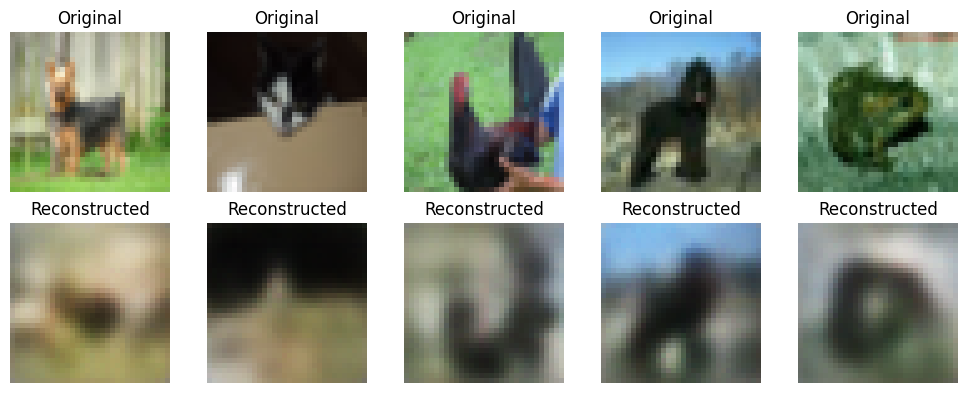

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  50/ 50  Batch:    1  Train Loss:  0.027815  LR:  1.00395e-05
Epoch:  50/ 50  Batch:  151  Train Loss:  0.027862  LR:  1.00395e-05
Epoch:  50/ 50  Batch:  301  Train Loss:  0.027755  LR:  1.00395e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      50 │           0.0284 │ 4.87s  │
╘═════════╧══════════════════╧════════╛


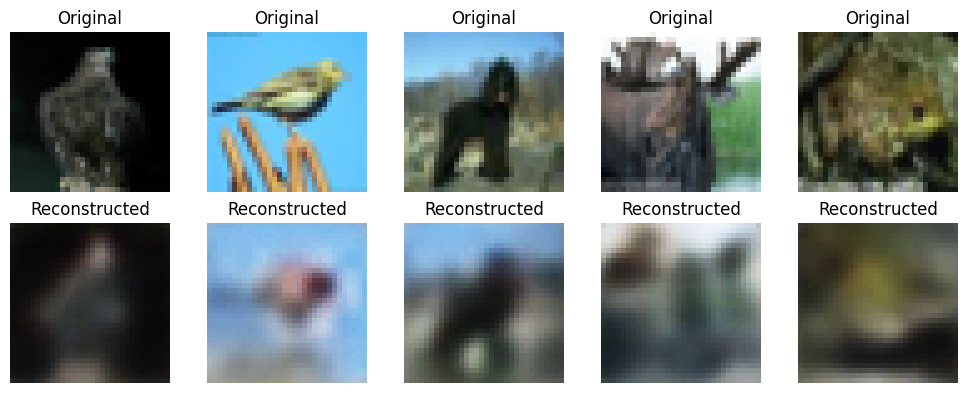

-----------------------------------------------------------------------------------------------------------------------------


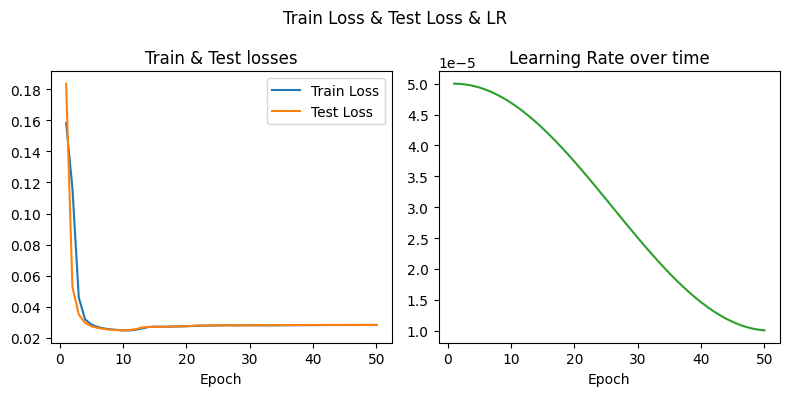

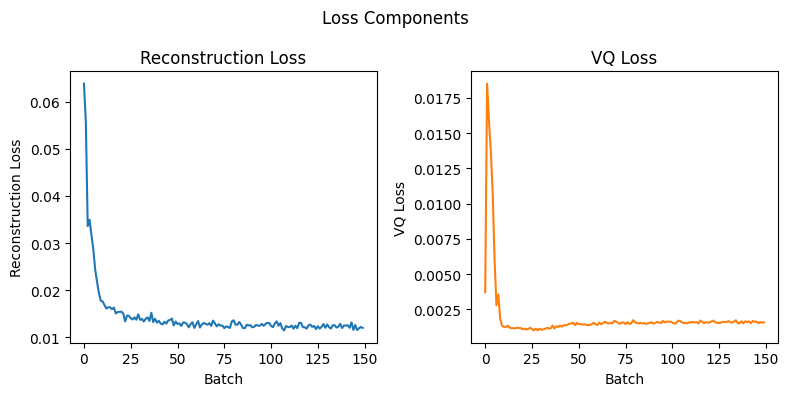

In [49]:
# Suppress user warnings
warnings.filterwarnings("ignore", category=UserWarning)

# We want to plot loss, its components and learning rate at the end of training
train_losses = []
test_losses = []
learning_rates = []
reconstruction_losses = []
sec_losses = []

# Training loop
for epoch in range(num_epochs):
  print('-----------------------------------------------------------------------------------------------------------------------------')
  model.train()
  losses = []

  # Start of time measurement
  epoch_start_time = time.time()

  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()

    with torch.cuda.amp.autocast():
      if model_option == 'vae':
        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Compute loss
        loss, recon_loss, sec_loss = loss_function(recon_batch, data, mu, logvar)
      else:
        # Forward pass
        recon_batch, vq_loss = model(data)

        # Compute loss
        loss, recon_loss, sec_loss = loss_function(recon_batch, data, vq_loss)

    # Backward pass
    scaler.scale(loss).backward()

    # Optimization step
    scaler.step(optimizer)
    scaler.update()

    # Save the loss value for current batch
    curr_loss = loss.detach().clone()
    losses.append(curr_loss)

    # Log training loss and current learning rate
    if batch_idx % output_frequency == 0:
      reconstruction_losses.append(recon_loss.detach().clone())
      sec_losses.append(sec_loss.detach().clone())

      log = [['Epoch:', f'{epoch + 1:3d}/{num_epochs:3d}', 'Batch:', f'{batch_idx + 1:3d}',
              'Train Loss:', f'{curr_loss:.6f}', 'LR:', scheduler.get_last_lr()[0]]]
      print(tabulate(log, tablefmt="plain"))

  # Step the learning rate scheduler
  if scheduler is not None:
    lr = scheduler.get_last_lr()[0]
    scheduler.step()
  else:
    lr = learning_rate
  learning_rates.append(lr)

  # After the epoch, evaluate the accuracy on the test dataset
  mean_loss = evaluate(model_option, model, test_loader, loss_function, device)
  test_losses.append(mean_loss)

  # Save the average training loss
  average_loss = torch.stack(losses).mean().item()
  train_losses.append(average_loss)

  # End of time measurement
  elapsed_time = time.time() - epoch_start_time

  # Log as a horizontal table
  headers = ["Epoch", "Mean Test Loss", "Time"]
  data = [[epoch + 1, f"{mean_loss:.4f}", f"{elapsed_time:.2f}s"]]
  print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

  # Generate reconstructed test images after each epoch
  plot_reconstruction(model, test_loader, device, num_samples=5)
  print('-----------------------------------------------------------------------------------------------------------------------------')

# Plot Train Loss & Test Loss & LR
plot_loss_lr(num_epochs, train_losses, test_losses, learning_rates)

# Plot each loss component
plot_loss_components(model_option, reconstruction_losses, sec_losses)

if model_option == 'vae':
  # Sample some VAE-generated images
  sample(model, device, latent_dim, num_samples=50)
